# Goal
Replicate (as close as possible) the 2024 paper pipeline on the D1NAMO Kaggle dataset.

Paper key ideas:
- Use ECG morphology + HRV features together.
- Train models at multiple glucose thresholds and fuse them.
- Use temporal 5-fold CV with 1-hour blocks.

In [55]:
# [Cell 1] Imports + basic setup
import os, re, glob, math, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("OK imports. Seed =", SEED)

OK imports. Seed = 42


In [56]:
# [Cell 2] Paths (from your .py)
DATA_ROOT = "/kaggle/input/d1namo-ecg-glucose-data"

DIAB_ECG_ROOT = os.path.join(DATA_ROOT, "diabetes_subset_ecg_data", "diabetes_subset_ecg_data")
HEAL_ECG_ROOT = os.path.join(DATA_ROOT, "healthy_subset_ecg_data", "healthy_subset_ecg_data")

# glucose/food/insulin folder (we mainly need glucose.csv)
DIAB_GLUCOSE_ROOT = os.path.join(DATA_ROOT, "diabetes_subset_pictures-glucose-food-insulin",
                                 "diabetes_subset_pictures-glucose-food-insulin")

print("DATA_ROOT:", DATA_ROOT)
print("DIAB_ECG_ROOT:", DIAB_ECG_ROOT)
print("HEAL_ECG_ROOT:", HEAL_ECG_ROOT)
print("DIAB_GLUCOSE_ROOT:", DIAB_GLUCOSE_ROOT)

DATA_ROOT: /kaggle/input/d1namo-ecg-glucose-data
DIAB_ECG_ROOT: /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data
HEAL_ECG_ROOT: /kaggle/input/d1namo-ecg-glucose-data/healthy_subset_ecg_data/healthy_subset_ecg_data
DIAB_GLUCOSE_ROOT: /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_pictures-glucose-food-insulin/diabetes_subset_pictures-glucose-food-insulin


In [57]:
# [Cell 3] Scan dataset and list files
def list_files(root, pattern="*.csv", max_show=10):
    files = sorted(glob.glob(os.path.join(root, "**", pattern), recursive=True))
    print(f"Root: {root}")
    print("Num files:", len(files))
    for f in files[:max_show]:
        print(" -", f)
    return files

diab_ecg_files = list_files(DIAB_ECG_ROOT, pattern="*_ECG.csv", max_show=5)
heal_ecg_files = list_files(HEAL_ECG_ROOT, pattern="*_ECG.csv", max_show=5)

glucose_files = sorted(glob.glob(os.path.join(DIAB_GLUCOSE_ROOT, "**", "glucose.csv"), recursive=True))
print("\nGlucose files:", len(glucose_files))
for f in glucose_files[:5]:
    print(" -", f)

Root: /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data
Num files: 47
 - /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data/001/sensor_data/2014_10_01-10_09_39/2014_10_01-10_09_39_ECG.csv
 - /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data/001/sensor_data/2014_10_02-10_56_44/2014_10_02-10_56_44_ECG.csv
 - /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data/001/sensor_data/2014_10_03-06_36_24/2014_10_03-06_36_24_ECG.csv
 - /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data/001/sensor_data/2014_10_04-06_34_57/2014_10_04-06_34_57_ECG.csv
 - /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data/002/sensor_data/2014_10_01-12_35_54/2014_10_01-12_35_54_ECG.csv
Root: /kaggle/input/d1namo-ecg-glucose-data/healthy_subset_ecg_data/healthy_subset_ecg_data
Num files: 84
 - /kaggle/

In [58]:
# [Cell 4] Helpers to parse subject/session from path
def parse_subject_id(path):
    # expects .../<SUBJECT>/sensor_data/<SESSION>/<SESSION>_ECG.csv
    parts = path.replace("\\", "/").split("/")
    # find the subject folder as the last 3-digit token (001, 002, ...)
    for p in parts:
        if re.fullmatch(r"\d{3}", p):
            return p
    return None

def parse_session_id(path):
    # session folder is usually like 2014_10_01-10_09_39
    parts = path.replace("\\", "/").split("/")
    for p in parts:
        if re.fullmatch(r"\d{4}_\d{2}_\d{2}-\d{2}_\d{2}_\d{2}", p):
            return p
    return None

# quick check
if len(diab_ecg_files) > 0:
    test = diab_ecg_files[0]
    print("Example ECG:", test)
    print("subject:", parse_subject_id(test))
    print("session:", parse_session_id(test))

Example ECG: /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_ecg_data/diabetes_subset_ecg_data/001/sensor_data/2014_10_01-10_09_39/2014_10_01-10_09_39_ECG.csv
subject: 001
session: 2014_10_01-10_09_39


ECG shape: (11006750, 2)
Columns: ['Time', 'EcgWaveform']


,Time,EcgWaveform
0,01/10/2014 10:09:39.417,297
1,01/10/2014 10:09:39.421,297
2,01/10/2014 10:09:39.425,297
3,01/10/2014 10:09:39.429,297
4,01/10/2014 10:09:39.433,297


Using signal column: EcgWaveform


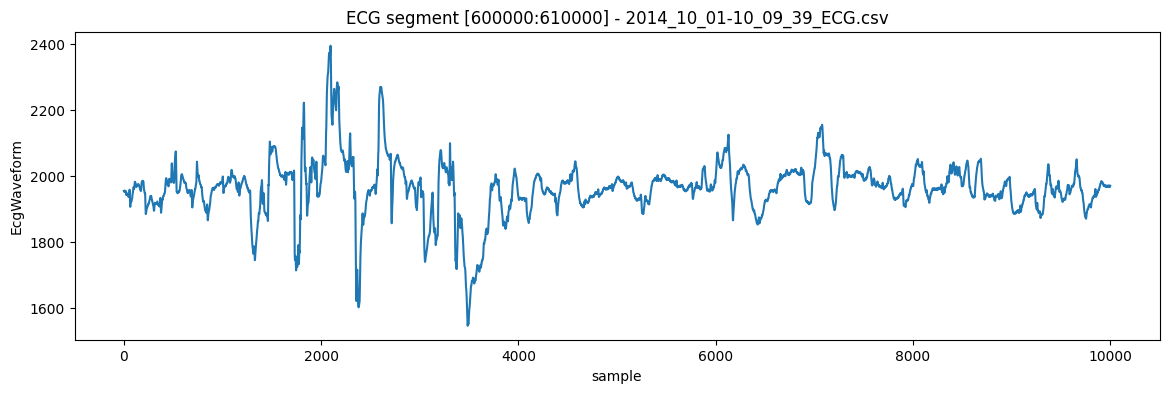

In [59]:
# [Cell 5] Load 1 ECG file + quick plots
ecg_path = diab_ecg_files[0] if len(diab_ecg_files) else None
assert ecg_path is not None, "No ECG files found."

df_ecg = pd.read_csv(ecg_path)
print("ECG shape:", df_ecg.shape)
print("Columns:", list(df_ecg.columns))
display(df_ecg.head())

# pick a numeric column to plot (robust)
numeric_cols = df_ecg.select_dtypes(include=[np.number]).columns.tolist()
assert len(numeric_cols) > 0, "No numeric columns in ECG csv."

# try common names first
preferred = [c for c in numeric_cols if c.lower() in ["ecg", "ecg_mv", "signal", "value"]]
sig_col = preferred[0] if len(preferred) else numeric_cols[0]

print("Using signal column:", sig_col)

# plot a small window
start = 600000
end = start + 10000
seg = df_ecg.iloc[start:end][sig_col].values

plt.figure(figsize=(14,4))
plt.plot(seg)
plt.title(f"ECG segment [{start}:{end}] - {os.path.basename(ecg_path)}")
plt.xlabel("sample")
plt.ylabel(sig_col)
plt.show()

Glucose shape: (1438, 5)
Columns: ['date', 'time', 'glucose', 'type', 'comments']


,date,time,glucose,type,comments
0,2014-10-01,19:14:00,10.3,cgm,NaN
1,2014-10-01,19:19:00,9.9,cgm,NaN
2,2014-10-01,19:23:00,9.4,manual,NaN
3,2014-10-01,19:24:00,9.8,cgm,NaN
4,2014-10-01,19:29:00,9.6,cgm,NaN


,date,time,glucose,type,comments,Time,glucose_mg_dL
1433,2014-10-06,16:34:02,12.3,cgm,NaN,2014-10-06 16:34:02,221.4
1434,2014-10-06,16:39:02,12.5,cgm,NaN,2014-10-06 16:39:02,225.0
1435,2014-10-06,16:44:02,12.5,cgm,NaN,2014-10-06 16:44:02,225.0
1436,2014-10-06,16:49:02,12.3,cgm,NaN,2014-10-06 16:49:02,221.4
1437,2014-10-06,16:54:02,12.1,cgm,NaN,2014-10-06 16:54:02,217.8


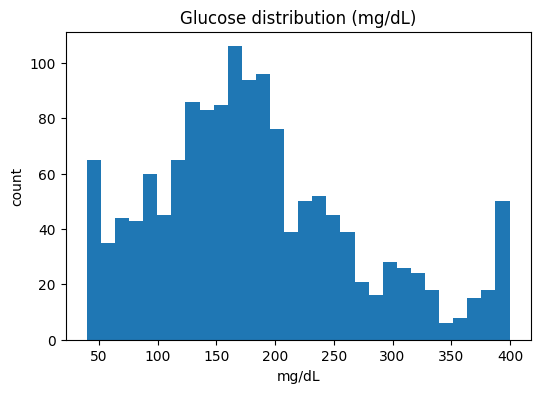

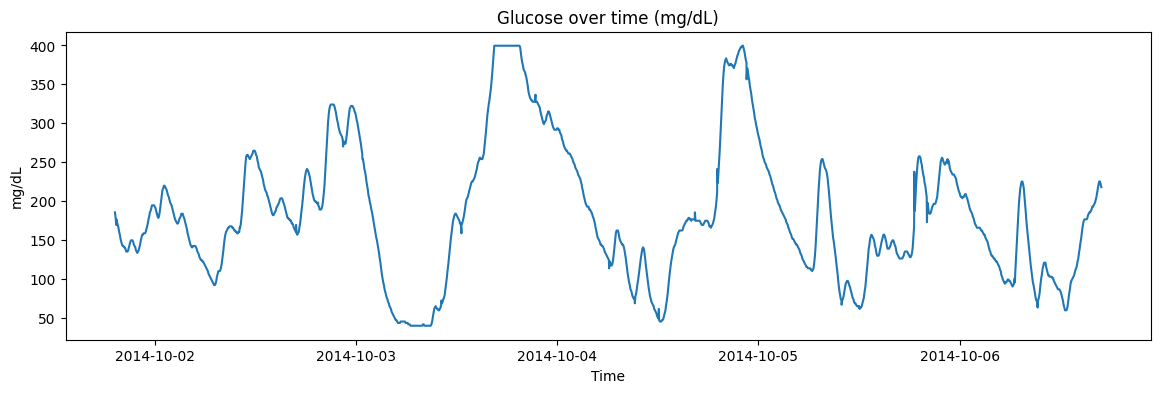

In [60]:
# [Cell 6] Load 1 glucose.csv + mg/dL + plots (from your .py logic)
glc_path = glucose_files[0] if len(glucose_files) else None
assert glc_path is not None, "No glucose.csv found."

df_g = pd.read_csv(glc_path)
print("Glucose shape:", df_g.shape)
print("Columns:", list(df_g.columns))
display(df_g.head())

# your .py: Time = date + " " + time, then to_datetime, then glucose*18
if ("date" in df_g.columns) and ("time" in df_g.columns):
    df_g["Time"] = pd.to_datetime(df_g["date"].astype(str) + " " + df_g["time"].astype(str), errors="coerce")
else:
    # fallback if already has datetime-like
    maybe_time = [c for c in df_g.columns if "time" in c.lower() or "date" in c.lower()]
    print("No (date,time) columns. Candidates:", maybe_time)

if "glucose" in df_g.columns:
    df_g["glucose_mg_dL"] = df_g["glucose"] * 18.0
else:
    # fallback: pick first numeric
    gnum = df_g.select_dtypes(include=[np.number]).columns.tolist()
    assert len(gnum) > 0, "No numeric glucose column found."
    df_g["glucose_mg_dL"] = df_g[gnum[0]].astype(float)

display(df_g.tail())

plt.figure(figsize=(6,4))
plt.hist(df_g["glucose_mg_dL"].dropna().values, bins=30)
plt.title("Glucose distribution (mg/dL)")
plt.xlabel("mg/dL")
plt.ylabel("count")
plt.show()

if "Time" in df_g.columns:
    plt.figure(figsize=(14,4))
    plt.plot(df_g["Time"], df_g["glucose_mg_dL"])
    plt.title("Glucose over time (mg/dL)")
    plt.xlabel("Time")
    plt.ylabel("mg/dL")
    plt.show()

In [79]:
# [Cell 7] Config ECG + utils (bandpass)
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt

FS = 250  # Hz (come nel tuo .py)
BANDPASS = (3.0, 45.0)  # Hz

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def apply_bandpass(x, fs=FS, lowcut=BANDPASS[0], highcut=BANDPASS[1], order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, x)

print("FS =", FS, "| BANDPASS =", BANDPASS)

FS = 250 | BANDPASS = (3.0, 45.0)


In [80]:
# [Cell 8] Session parsing (robust: YYYY_MM_DD vs YYYY_DD_MM)
import re

def parse_subject_id(path):
    parts = path.replace("\\", "/").split("/")
    for p in parts:
        if re.fullmatch(r"\d{3}", p):
            return p
    return None

def parse_session_id(path):
    parts = path.replace("\\", "/").split("/")
    for p in parts:
        if re.fullmatch(r"\d{4}_\d{2}_\d{2}-\d{2}_\d{2}_\d{2}", p):
            return p
    return None

def parse_session_datetime(sess_str):
    # sess_str example: 2014_10_01-10_09_39
    date_part, time_part = sess_str.split("-")
    hh, mm, ss = time_part.split("_")
    y, a, b = date_part.split("_")  # a and b ambiguous

    dt_A = datetime(int(y), int(a), int(b), int(hh), int(mm), int(ss))  # YYYY_MM_DD
    dt_B = datetime(int(y), int(b), int(a), int(hh), int(mm), int(ss))  # YYYY_DD_MM
    return dt_A, dt_B

sess = parse_session_id(ecg_path)
dtA, dtB = parse_session_datetime(sess)
print("Session folder:", sess)
print("Candidate A (YYYY_MM_DD):", dtA)
print("Candidate B (YYYY_DD_MM):", dtB)

Session folder: 2014_10_01-10_09_39
Candidate A (YYYY_MM_DD): 2014-10-01 10:09:39
Candidate B (YYYY_DD_MM): 2014-01-10 10:09:39


In [81]:
# [Cell 9] Load ECG session (raw + filtered). Time is temporary; we will rebuild it after choosing best alignment.
def load_ecg_session_signal_only(ecg_path, fs=FS):
    df = pd.read_csv(ecg_path)

    # signal column preference
    if "EcgWaveform" in df.columns:
        raw = pd.to_numeric(df["EcgWaveform"], errors="coerce").values
    else:
        num = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(num) == 0:
            raise ValueError("No numeric ECG column found.")
        raw = pd.to_numeric(df[num[0]], errors="coerce").values
        print("WARNING: EcgWaveform not found. Using:", num[0])

    # ADC -> mV heuristic (come nel tuo .py: (x-1024)/200)
    raw_clean = raw[~np.isnan(raw)]
    if len(raw_clean) > 0 and (np.nanpercentile(raw_clean, 95) > 50):
        ecg_mv = (raw.astype(float) - 1024.0) / 200.0
        conv_used = True
    else:
        ecg_mv = raw.astype(float)
        conv_used = False

    ecg_filt = apply_bandpass(np.nan_to_num(ecg_mv), fs=fs)

    out = pd.DataFrame({
        "ecg_mv": ecg_mv,
        "ecg_filt": ecg_filt
    })
    return out, conv_used

df_ecg_sess, used_conv = load_ecg_session_signal_only(ecg_path)
print("ECG samples:", len(df_ecg_sess), "| used ADC->mV conversion:", used_conv)
display(df_ecg_sess.head())

ECG samples: 11006750 | used ADC->mV conversion: True


,ecg_mv,ecg_filt
0,-3.635,-1.001846e-14
1,-3.635,-9.986451e-15
2,-3.635,-9.828885e-15
3,-3.635,-9.542188e-15
4,-3.635,-9.192389e-15


Best window i0: 4552500 std: 2.9851511234196146


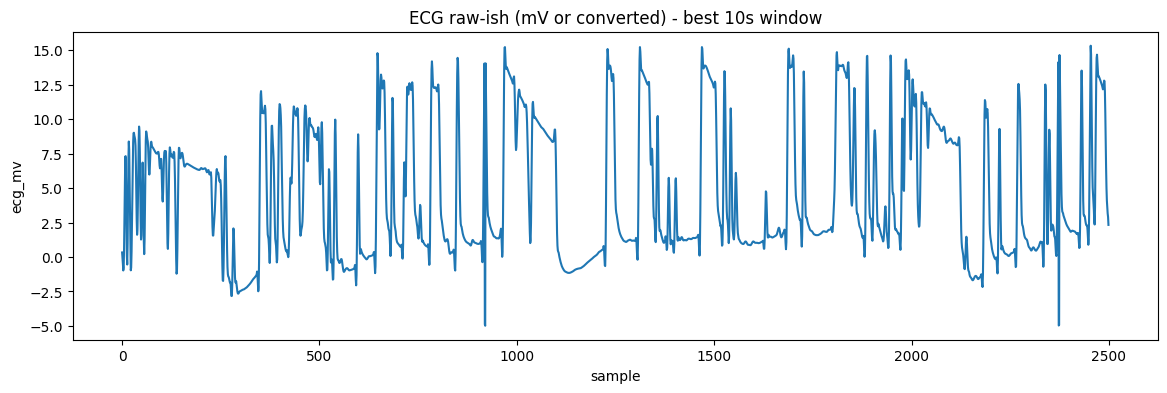

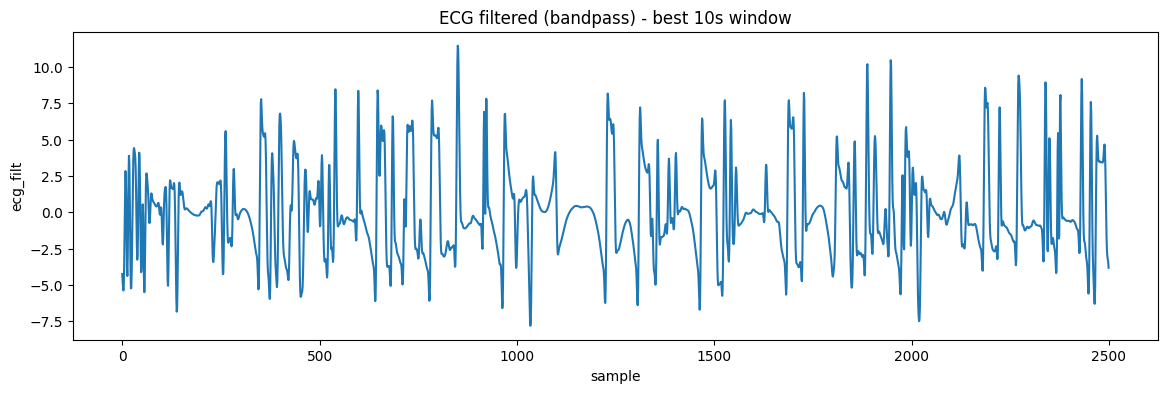

In [82]:
# [Cell 10] Plot ECG sanity (auto-pick a 'good' 10s window)
def pick_best_window(ecg_filt, fs=FS, win_sec=5):
    x = np.asarray(ecg_filt, dtype=float)
    chunk = fs * win_sec
    best_i0, best_std = 0, -1
    for i0 in range(0, len(x) - chunk, chunk):
        s = np.nanstd(x[i0:i0+chunk])
        if s > best_std:
            best_std = s
            best_i0 = i0
    return best_i0, best_std

i0, s0 = pick_best_window(df_ecg_sess["ecg_filt"].values, fs=FS, win_sec=5)
i1 = i0 + FS*10
print("Best window i0:", i0, "std:", s0)

plt.figure(figsize=(14,4))
plt.plot(df_ecg_sess["ecg_mv"].iloc[i0:i1].values)
plt.title("ECG raw-ish (mV or converted) - best 10s window")
plt.xlabel("sample")
plt.ylabel("ecg_mv")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df_ecg_sess["ecg_filt"].iloc[i0:i1].values)
plt.title("ECG filtered (bandpass) - best 10s window")
plt.xlabel("sample")
plt.ylabel("ecg_filt")
plt.show()

Best overlap hours: 12.229721111111111
Chosen glucose: /kaggle/input/d1namo-ecg-glucose-data/diabetes_subset_pictures-glucose-food-insulin/diabetes_subset_pictures-glucose-food-insulin/003/glucose.csv
Glucose dayfirst: False
ECG interpretation chosen: A
Glucose time: 2014-10-01 08:53:15 -> 2014-10-02 00:03:16


/tmp/ipykernel_55/961396776.py:6: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["Time"] = pd.to_datetime(


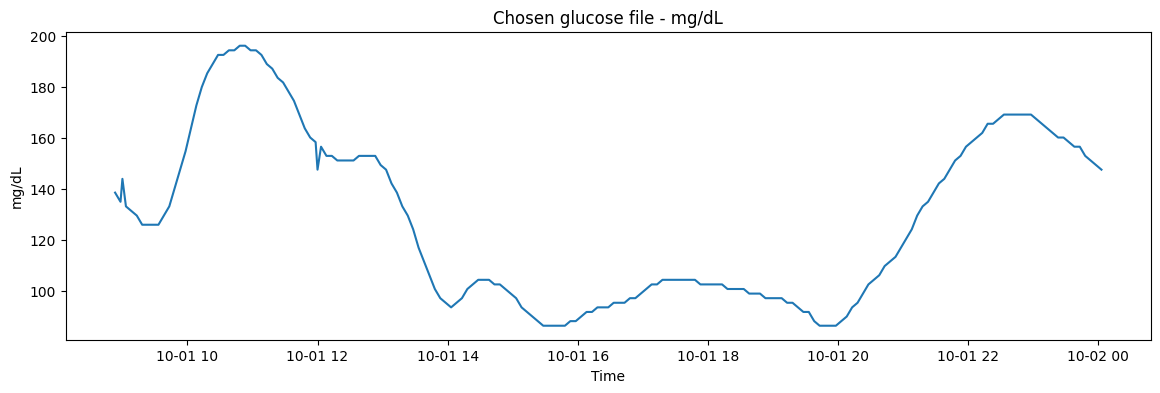

In [83]:
# [Cell 11] Robust glucose loader (tries dayfirst True/False) + choose best file by overlap with ECG session
def load_glucose_file(glc_path, dayfirst=False):
    df = pd.read_csv(glc_path)

    if ("date" in df.columns) and ("time" in df.columns):
        df["Time"] = pd.to_datetime(
            df["date"].astype(str) + " " + df["time"].astype(str),
            errors="coerce",
            dayfirst=dayfirst
        )
    elif "Time" in df.columns:
        df["Time"] = pd.to_datetime(df["Time"], errors="coerce", dayfirst=dayfirst)
    else:
        # try find time-ish col
        tc = None
        for c in df.columns:
            if "time" in c.lower() or "date" in c.lower():
                tc = c
                break
        if tc is None:
            return None
        df["Time"] = pd.to_datetime(df[tc], errors="coerce", dayfirst=dayfirst)

    if "glucose" in df.columns:
        df["glucose_mg_dL"] = pd.to_numeric(df["glucose"], errors="coerce") * 18.0
    else:
        gnum = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(gnum) == 0:
            return None
        df["glucose_mg_dL"] = pd.to_numeric(df[gnum[0]], errors="coerce")

    df = df[["Time", "glucose_mg_dL"]].dropna().sort_values("Time").reset_index(drop=True)
    if len(df) == 0:
        return None
    return df

def overlap_hours(t0, t1, u0, u1):
    ov0 = max(t0, u0)
    ov1 = min(t1, u1)
    sec = max(0.0, (ov1 - ov0).total_seconds())
    return sec / 3600.0

# build candidates (all glucose files * 2 dayfirst modes)
glc_candidates = []
for p in glucose_files:
    for dayfirst_flag in [False, True]:
        dfg = load_glucose_file(p, dayfirst=dayfirst_flag)
        if dfg is None:
            continue
        glc_candidates.append((p, dayfirst_flag, dfg))

assert len(glc_candidates) > 0, "No glucose candidates loaded."

# evaluate overlap for both ECG date interpretations (A/B) for each glucose candidate
best = None
sess = parse_session_id(ecg_path)
dtA, dtB = parse_session_datetime(sess)

N = len(df_ecg_sess)
dur = timedelta(seconds=(N-1)/FS)

for p, dayfirst_flag, dfg in glc_candidates:
    g0, g1 = dfg["Time"].min(), dfg["Time"].max()

    ecgA0, ecgA1 = dtA, dtA + dur
    ecgB0, ecgB1 = dtB, dtB + dur

    ovA = overlap_hours(ecgA0, ecgA1, g0, g1)
    ovB = overlap_hours(ecgB0, ecgB1, g0, g1)

    ov = max(ovA, ovB)
    which = "A" if ovA >= ovB else "B"

    cand = (ov, p, dayfirst_flag, which, g0, g1)
    if (best is None) or (cand[0] > best[0]):
        best = cand

ov, glc_path_subj, dayfirst_flag, which_ecg, g0, g1 = best
print("Best overlap hours:", ov)
print("Chosen glucose:", glc_path_subj)
print("Glucose dayfirst:", dayfirst_flag)
print("ECG interpretation chosen:", which_ecg)

# load chosen glucose df
df_g_subj = load_glucose_file(glc_path_subj, dayfirst=dayfirst_flag)
print("Glucose time:", df_g_subj["Time"].min(), "->", df_g_subj["Time"].max())

plt.figure(figsize=(14,4))
plt.plot(df_g_subj["Time"], df_g_subj["glucose_mg_dL"])
plt.title("Chosen glucose file - mg/dL")
plt.xlabel("Time")
plt.ylabel("mg/dL")
plt.show()

In [84]:
# [Cell 12] Rebuild ECG Time using chosen interpretation + create 1h windows + attach glucose mean
# rebuild ECG time
sess = parse_session_id(ecg_path)
dtA, dtB = parse_session_datetime(sess)
sess_dt = dtA if which_ecg == "A" else dtB

df_ecg_sess = df_ecg_sess.copy()
df_ecg_sess["Time"] = pd.to_datetime([sess_dt + timedelta(seconds=i/FS) for i in range(len(df_ecg_sess))])

print("ECG time:", df_ecg_sess["Time"].min(), "->", df_ecg_sess["Time"].max())

# ECG windows
ecg = df_ecg_sess.sort_values("Time").reset_index(drop=True).copy()
ecg["window_start"] = ecg["Time"].dt.floor("1h")

wins = (ecg.reset_index()
        .groupby("window_start")["index"]
        .agg(ecg_i0="min", ecg_i1="max")
        .reset_index())

wins["t_start"] = wins["window_start"]
wins["t_end"] = wins["window_start"] + pd.Timedelta("1h")

# glucose hourly mean
g = df_g_subj.copy()
g["window_start"] = g["Time"].dt.floor("1h")
g_hour = (g.groupby("window_start")["glucose_mg_dL"]
          .mean()
          .reset_index()
          .rename(columns={"glucose_mg_dL": "glucose_mean"}))

wins = wins.merge(g_hour, on="window_start", how="left")
wins = wins.sort_values("window_start").reset_index(drop=True)

print("Num windows:", len(wins))
print("Glucose available %:", (1 - wins["glucose_mean"].isna().mean()) * 100)
display(wins.head(10))

ECG time: 2014-10-01 10:09:39 -> 2014-10-01 22:23:25.996000
Num windows: 13
Glucose available %: 100.0


,window_start,ecg_i0,ecg_i1,t_start,t_end,glucose_mean
0,2014-10-01 10:00:00,0,755249,2014-10-01 10:00:00,2014-10-01 11:00:00,187.650000
1,2014-10-01 11:00:00,755250,1655249,2014-10-01 11:00:00,2014-10-01 12:00:00,177.750000
2,2014-10-01 12:00:00,1655250,2555249,2014-10-01 12:00:00,2014-10-01 13:00:00,152.030769
3,2014-10-01 13:00:00,2555250,3455249,2014-10-01 13:00:00,2014-10-01 14:00:00,120.300000
4,2014-10-01 14:00:00,3455250,4355249,2014-10-01 14:00:00,2014-10-01 15:00:00,100.650000
5,2014-10-01 15:00:00,4355250,5255249,2014-10-01 15:00:00,2014-10-01 16:00:00,89.100000
6,2014-10-01 16:00:00,5255250,6155249,2014-10-01 16:00:00,2014-10-01 17:00:00,94.500000
7,2014-10-01 17:00:00,6155250,7055249,2014-10-01 17:00:00,2014-10-01 18:00:00,103.500000
8,2014-10-01 18:00:00,7055250,7955249,2014-10-01 18:00:00,2014-10-01 19:00:00,100.200000
9,2014-10-01 19:00:00,7955250,8855249,2014-10-01 19:00:00,2014-10-01 20:00:00,91.350000


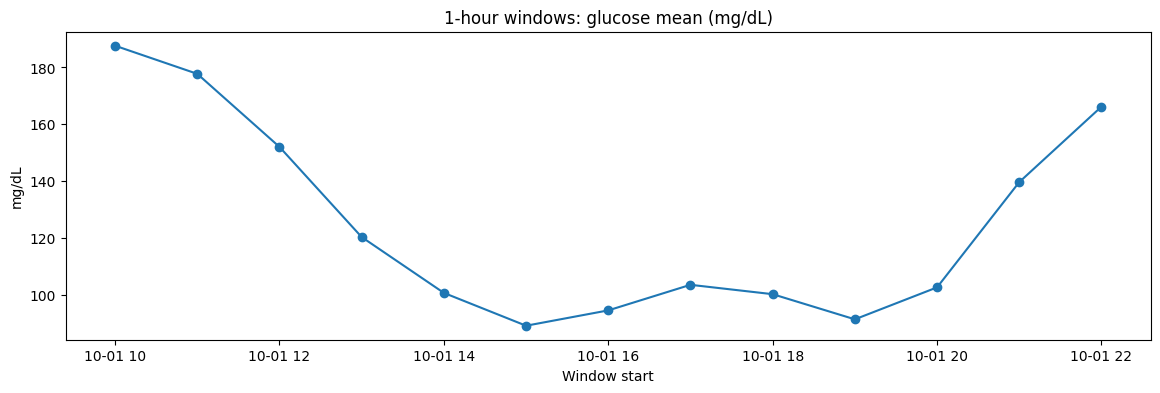

Example window row:
window_start    2014-10-01 16:00:00
ecg_i0                      5255250
ecg_i1                      6155249
t_start         2014-10-01 16:00:00
t_end           2014-10-01 17:00:00
glucose_mean                   94.5
Name: 6, dtype: object


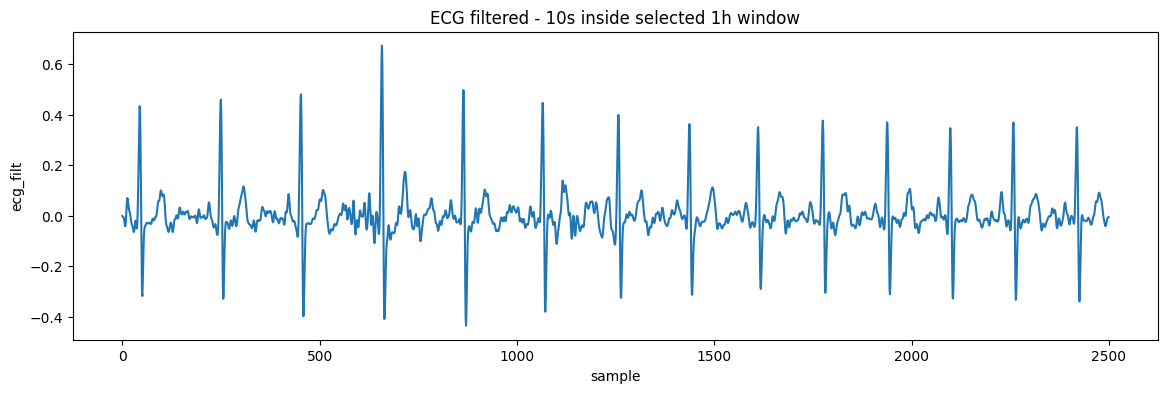

In [85]:
# [Cell 13] Plot windows glucose + show one example ECG segment inside a chosen window
plt.figure(figsize=(14,4))
plt.plot(wins["window_start"], wins["glucose_mean"], marker="o")
plt.title("1-hour windows: glucose mean (mg/dL)")
plt.xlabel("Window start")
plt.ylabel("mg/dL")
plt.show()

ok = wins.dropna(subset=["glucose_mean"])
assert len(ok) > 0, "No windows with glucose available."

w = ok.iloc[len(ok)//2]
print("Example window row:")
print(w)

ii0 = int(w["ecg_i0"])
ii1 = int(min(w["ecg_i1"], ii0 + FS*10))
seg = ecg["ecg_filt"].iloc[ii0:ii1].values

plt.figure(figsize=(14,4))
plt.plot(seg)
plt.title("ECG filtered - 10s inside selected 1h window")
plt.xlabel("sample")
plt.ylabel("ecg_filt")
plt.show()

In [86]:
# [Cell 14] Quick checks: counts + glucose stats per session windows
print("Windows covered hours:", (wins["t_end"].max() - wins["t_start"].min()).total_seconds() / 3600)

print("\nGlucose stats over windows:")
display(wins["glucose_mean"].describe())

# show first/last timestamps for ECG and glucose
print("\nECG:", df_ecg_sess["Time"].min(), "->", df_ecg_sess["Time"].max())
print("Glucose:", df_g_subj["Time"].min(), "->", df_g_subj["Time"].max())

Windows covered hours: 13.0

Glucose stats over windows:


count     13.000000
mean     125.036982
std       35.232250
min       89.100000
25%      100.200000
50%      103.500000
75%      152.030769
max      187.650000
Name: glucose_mean, dtype: float64


ECG: 2014-10-01 10:09:39 -> 2014-10-01 22:23:25.996000
Glucose: 2014-10-01 08:53:15 -> 2014-10-02 00:03:16


# Sezione 3

In [101]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 9.8 MB/s eta 0:00:00:00:0100:01


In [113]:
# =========================
# [Cell 15] Imports + optional NeuroKit2
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, iirnotch, find_peaks

USE_NK = True
try:
    import neurokit2 as nk
except Exception:
    USE_NK = False
    print("NeuroKit2 not available -> using scipy fallback. (pip install neurokit2)")

FS = 250  # keep consistent with Pezzo 2 (d1namo ECG usually 250 Hz)
print("USE_NK:", USE_NK, "| FS:", FS)

USE_NK: True | FS: 250


In [114]:
# =========================
# [Cell 16] Signal processing helpers (bandpass + notch)
# =========================

def bandpass(x, fs=FS, low=0.5, high=40.0, order=4):
    nyq = fs / 2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, x)

def notch50(x, fs=FS, f0=50.0, Q=30.0):
    w0 = f0 / (fs/2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, x)

def pick_ecg_col(df):
    for c in ["ecg_filt", "ECG_Clean", "ecg", "ECG", "signal", "value", "EcgWaveform"]:
        if c in df.columns:
            return c
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(nums) == 0:
        raise ValueError("No numeric ECG column found.")
    return nums[0]

ECG_COL = pick_ecg_col(ecg)
print("Using ECG column:", ECG_COL)

Using ECG column: ecg_filt


In [115]:
# =========================
# [Cell 17] Beat extraction + template correlation (quality proxy)
# =========================

def extract_beats(sig, rpeaks, fs=FS, pre_s=0.25, post_s=0.45):
    pre = int(pre_s * fs)
    post = int(post_s * fs)
    beats = []
    keep = []
    for i, rp in enumerate(rpeaks):
        if rp - pre < 0 or rp + post >= len(sig):
            continue
        beats.append(sig[rp-pre:rp+post])
        keep.append(i)
    if len(beats) == 0:
        return np.empty((0, pre+post)), np.array([], dtype=int)
    return np.vstack(beats), np.array(keep, dtype=int)

def template_corr(beats):
    if beats.shape[0] < 3:
        return np.array([])
    tmpl = np.median(beats, axis=0)
    tmpl = tmpl - np.mean(tmpl)
    tnorm = np.linalg.norm(tmpl) + 1e-12
    corrs = []
    for b in beats:
        bb = b - np.mean(b)
        cn = np.dot(bb, tmpl) / ((np.linalg.norm(bb) + 1e-12) * tnorm)
        corrs.append(float(cn))
    return np.array(corrs, dtype=float)

In [116]:
# =========================
# [Cell 18] RR cleaning (MAD) + HRV time features
# =========================

def mad_filter_rr(rr_ms, z_th=3.5):
    rr_ms = np.asarray(rr_ms, dtype=float)
    rr_ms = rr_ms[np.isfinite(rr_ms)]
    if len(rr_ms) < 5:
        return rr_ms
    med = np.median(rr_ms)
    mad = np.median(np.abs(rr_ms - med)) + 1e-12
    z = 0.6745 * (rr_ms - med) / mad
    return rr_ms[np.abs(z) < z_th]

def hrv_time_features(rr_ms):
    rr_ms = np.asarray(rr_ms, dtype=float)
    rr_ms = rr_ms[np.isfinite(rr_ms)]
    if len(rr_ms) < 10:
        return {}

    diff = np.diff(rr_ms)
    return {
        "rr_mean_ms": float(np.mean(rr_ms)),
        "rr_std_ms": float(np.std(rr_ms, ddof=1)) if len(rr_ms) > 1 else np.nan,
        "rmssd_ms": float(np.sqrt(np.mean(diff**2))) if len(diff) > 0 else np.nan,
        "pnn50": float(np.mean(np.abs(diff) > 50.0)) if len(diff) > 0 else np.nan,
        "hr_mean_bpm": float(60000.0 / np.mean(rr_ms)) if np.mean(rr_ms) > 0 else np.nan,
        "hr_std_bpm": float(np.std(60000.0 / rr_ms, ddof=1)) if len(rr_ms) > 1 else np.nan,
    }

In [117]:
# =========================
# [Cell 19] HRV frequency features (LF/HF) from R-peaks (correct NK usage)
# =========================

def hrv_freq_from_rpeaks(rpeaks, fs=FS):
    """
    LF/HF using NeuroKit2 from peaks.
    Needs enough beats; otherwise returns NaNs.
    """
    if (not USE_NK) or (rpeaks is None) or (len(rpeaks) < 150):
        return {"lf_power": np.nan, "hf_power": np.nan, "lf_hf": np.nan}

    try:
        peaks = {"ECG_R_Peaks": np.asarray(rpeaks, dtype=int)}
        hrvf = nk.hrv_frequency(
            peaks,
            sampling_rate=fs,
            interpolation_rate=4,
            show=False
        )
        return {
            "lf_power": float(hrvf["HRV_LF"].values[0]),
            "hf_power": float(hrvf["HRV_HF"].values[0]),
            "lf_hf": float(hrvf["HRV_LFHF"].values[0]),
        }
    except Exception:
        return {"lf_power": np.nan, "hf_power": np.nan, "lf_hf": np.nan}

In [118]:
# =========================
# [Cell 20] Feature extraction per window (paper-like) + build feat_df
# =========================

def compute_window_features(ecg_df, i0, i1, fs=FS, ecg_col=ECG_COL, corr_thr=0.90):
    seg = ecg_df.iloc[i0:i1+1]
    x = pd.to_numeric(seg[ecg_col], errors="coerce").to_numpy(dtype=float)
    x = np.nan_to_num(x)

    # cleaning
    x = bandpass(x, fs=fs, low=0.5, high=40.0, order=4)
    x = notch50(x, fs=fs, f0=50.0, Q=30.0)

    # R-peaks
    if USE_NK:
        try:
            x_clean = nk.ecg_clean(x, sampling_rate=fs)
            _, info = nk.ecg_peaks(x_clean, sampling_rate=fs)
            rpeaks = np.array(info["ECG_R_Peaks"], dtype=int)
            x_use = x_clean
        except Exception:
            rpeaks = np.array([], dtype=int)
            x_use = x
    else:
        prom = max(0.02, np.std(x) * 0.5)
        rpeaks, _ = find_peaks(x, distance=int(0.30*fs), prominence=prom)
        rpeaks = np.array(rpeaks, dtype=int)
        x_use = x

    feats = {
        "n_rpeaks": int(len(rpeaks)),
        "sig_std": float(np.std(x_use)),
        "sig_kurtosis": float(pd.Series(x_use).kurtosis()),
        "abs_mean": float(np.mean(np.abs(x_use))),
        "flat_ratio": float(np.mean(np.abs(np.diff(x_use)) < 1e-3)),
    }

    if len(rpeaks) < 30:
        feats.update({
            "n_beats": 0,
            "template_corr_mean": np.nan,
            "template_corr_std": np.nan,
            "rr_outlier_frac": np.nan,
            "rr_mean_ms": np.nan, "rr_std_ms": np.nan, "rmssd_ms": np.nan, "pnn50": np.nan,
            "hr_mean_bpm": np.nan, "hr_std_bpm": np.nan,
            "lf_power": np.nan, "hf_power": np.nan, "lf_hf": np.nan
        })
        return feats, {"n_rpeaks": int(len(rpeaks)), "corr_mean": np.nan}

    # beat quality via template correlation
    beats, keep = extract_beats(x_use, rpeaks, fs=fs, pre_s=0.25, post_s=0.45)
    corrs = template_corr(beats)

    if len(corrs) == 0:
        feats.update({
            "n_beats": 0,
            "template_corr_mean": np.nan,
            "template_corr_std": np.nan,
            "rr_outlier_frac": np.nan,
            "rr_mean_ms": np.nan, "rr_std_ms": np.nan, "rmssd_ms": np.nan, "pnn50": np.nan,
            "hr_mean_bpm": np.nan, "hr_std_bpm": np.nan,
            "lf_power": np.nan, "hf_power": np.nan, "lf_hf": np.nan
        })
        return feats, {"n_rpeaks": int(len(rpeaks)), "corr_mean": np.nan}

    rpeaks_keep = rpeaks[keep]
    good = corrs >= corr_thr

    # if too strict -> fallback to all kept beats
    if np.sum(good) < 30:
        good = np.ones_like(corrs, dtype=bool)

    rpeaks_good = rpeaks_keep[good]
    corr_mean = float(np.mean(corrs[good]))
    corr_std = float(np.std(corrs[good]))

    feats.update({
        "n_beats": int(len(rpeaks_good)),
        "template_corr_mean": corr_mean,
        "template_corr_std": corr_std,
    })

    # RR from good peaks
    rr_ms = (np.diff(rpeaks_good) / fs) * 1000.0

    # physiologic filter
    rr_ms = rr_ms[(rr_ms > 300) & (rr_ms < 2000)]
    if len(rr_ms) < 30:
        feats.update({
            "rr_outlier_frac": np.nan,
            "rr_mean_ms": np.nan, "rr_std_ms": np.nan, "rmssd_ms": np.nan, "pnn50": np.nan,
            "hr_mean_bpm": np.nan, "hr_std_bpm": np.nan,
            "lf_power": np.nan, "hf_power": np.nan, "lf_hf": np.nan
        })
        return feats, {"n_rpeaks": int(len(rpeaks)), "corr_mean": corr_mean}

    # outlier frac BEFORE MAD cleanup
    rr_med = np.median(rr_ms)
    rr_mad = np.median(np.abs(rr_ms - rr_med)) + 1e-12
    rr_z = 0.6745 * (rr_ms - rr_med) / rr_mad
    rr_out = np.abs(rr_z) > 3.5
    feats["rr_outlier_frac"] = float(np.mean(rr_out))

    rr_ms_clean = mad_filter_rr(rr_ms, z_th=3.5)

    feats.update(hrv_time_features(rr_ms_clean))
    feats.update(hrv_freq_from_rpeaks(rpeaks_good, fs=fs))

    # optional morphology via delineation
    if USE_NK:
        try:
            deln = nk.ecg_delineate(
                x_use, rpeaks_good, sampling_rate=fs, method="dwt", show=False
            )[1]

            P = np.array(deln.get("ECG_P_Peaks", []), dtype=float)
            Q = np.array(deln.get("ECG_Q_Peaks", []), dtype=float)
            S = np.array(deln.get("ECG_S_Peaks", []), dtype=float)
            T = np.array(deln.get("ECG_T_Peaks", []), dtype=float)
            R = rpeaks_good.astype(float)

            def interval_ms(a, b):
                m = np.isfinite(a) & np.isfinite(b)
                if np.sum(m) < 10:
                    return np.nan, np.nan
                vals = (b[m] - a[m]) * 1000.0 / fs
                return float(np.mean(vals)), float(np.std(vals))

            for name, (a, b) in {
                "pr": (P, R),
                "qr": (Q, R),
                "rs": (R, S),
                "qt": (Q, T),
                "rt": (R, T),
                "st": (S, T),
            }.items():
                m, s = interval_ms(a, b)
                feats[f"{name}_mean_ms"] = m
                feats[f"{name}_std_ms"] = s

        except Exception:
            pass

    return feats, {"n_rpeaks": int(len(rpeaks)), "corr_mean": corr_mean}


# ---- run feature extraction on all windows
rows = []

for k, w in wins.iterrows():
    feats, dbg = compute_window_features(
        ecg,
        int(w["ecg_i0"]),
        int(w["ecg_i1"]),
        fs=FS,
        ecg_col=ECG_COL,
        corr_thr=0.90  # you used this
    )

    out = w.to_dict()
    out.update(feats)
    rows.append(out)

    if (k + 1) % 3 == 1 or (k + 1) == len(wins):
        print(f"done {k+1}/{len(wins)} | n_rpeaks={dbg['n_rpeaks']} | corr_mean={dbg['corr_mean']}")

feat_df = pd.DataFrame(rows).sort_values("window_start").reset_index(drop=True)
print("feat_df shape:", feat_df.shape)
display(feat_df.head(10))

done 1/13 | n_rpeaks=3526 | corr_mean=0.506113412326468
done 4/13 | n_rpeaks=4240 | corr_mean=0.9261024569826288
done 7/13 | n_rpeaks=4976 | corr_mean=0.9769891655202868
done 10/13 | n_rpeaks=4815 | corr_mean=0.9588148618065074
done 13/13 | n_rpeaks=1561 | corr_mean=0.9644657367190733
feat_df shape: (13, 36)


,window_start,ecg_i0,ecg_i1,t_start,t_end,glucose_mean,n_rpeaks,sig_std,sig_kurtosis,abs_mean,flat_ratio,n_beats,template_corr_mean,template_corr_std,rr_outlier_frac,rr_mean_ms,rr_std_ms,rmssd_ms,pnn50,hr_mean_bpm,hr_std_bpm,lf_power,hf_power,lf_hf,pr_mean_ms,pr_std_ms,qr_mean_ms,qr_std_ms,rs_mean_ms,rs_std_ms,qt_mean_ms,qt_std_ms,rt_mean_ms,rt_std_ms,st_mean_ms,st_std_ms
0,2014-10-01 10:00:00,0,755249,2014-10-01 10:00:00,2014-10-01 11:00:00,187.650000,3526,0.452328,36.427390,0.188084,0.120769,3525,0.506113,0.224983,0.067200,704.969851,215.889504,296.073213,0.673333,85.110023,29.012925,0.001393,1.069038e-03,1.303382,165.279952,49.240192,62.965067,36.922898,71.839955,48.759008,229.316113,82.009028,166.626114,67.457381,100.442396,61.716967
1,2014-10-01 11:00:00,755250,1655249,2014-10-01 11:00:00,2014-10-01 12:00:00,177.750000,4541,0.213256,76.301285,0.085913,0.141926,296,0.926123,0.015858,0.225806,691.541667,49.174644,48.886550,0.200000,86.762668,6.120358,0.000006,5.905205e-08,104.750296,510.783784,67.981967,61.256757,62.014724,39.932432,2.856151,292.864865,75.819901,231.608108,44.648876,191.675676,44.562773
2,2014-10-01 12:00:00,1655250,2555249,2014-10-01 12:00:00,2014-10-01 13:00:00,152.030769,4647,0.075844,871.613010,0.036407,0.195097,868,0.945854,0.023327,0.195876,787.346154,63.066611,46.444241,0.160772,76.205364,5.758005,0.000510,6.539234e-06,78.017686,510.857143,56.352600,49.548387,24.020704,36.672811,6.675414,295.488479,48.815047,245.940092,42.500812,209.267281,43.082147
3,2014-10-01 13:00:00,2555250,3455249,2014-10-01 13:00:00,2014-10-01 14:00:00,120.300000,4240,0.065266,123.585416,0.033318,0.204720,227,0.926102,0.016556,0.166667,817.090909,55.885887,54.550011,0.277778,73.431242,5.014284,0.000004,4.746402e-08,84.101088,1145.208889,91.939864,61.215859,72.089043,87.665198,168.586225,320.951542,84.713627,259.735683,44.909313,172.070485,172.228704
4,2014-10-01 14:00:00,3455250,4355249,2014-10-01 14:00:00,2014-10-01 15:00:00,100.650000,4558,0.325169,50.660175,0.124910,0.133768,493,0.923241,0.015503,0.238482,658.234875,66.138073,41.081104,0.103571,91.152873,8.862450,0.000029,8.253864e-07,35.086315,124.916836,24.905891,46.742394,21.153946,32.219067,23.707153,216.965517,63.718009,170.223124,62.068134,138.004057,67.941330
5,2014-10-01 15:00:00,4355250,5255249,2014-10-01 15:00:00,2014-10-01 16:00:00,89.100000,5715,0.670602,24.093877,0.258244,0.095387,2693,0.962081,0.023136,0.061802,645.242669,76.401727,31.678981,0.074405,92.988271,10.810573,0.000001,1.819708e-08,65.303334,114.660230,12.341925,44.562941,16.289921,30.514668,1.941846,220.337170,57.889705,175.774229,57.117876,145.259562,57.058532
6,2014-10-01 16:00:00,5255250,6155249,2014-10-01 16:00:00,2014-10-01 17:00:00,94.500000,4976,0.071514,8.061719,0.042355,0.191095,4675,0.976989,0.018725,0.022664,730.590106,77.586830,29.943825,0.076209,82.125394,8.974363,0.004878,2.218572e-03,2.198778,121.893476,11.971222,46.016684,13.620578,30.699465,1.891877,222.039786,69.112146,176.023102,69.863999,145.323636,69.880315
7,2014-10-01 17:00:00,6155250,7055249,2014-10-01 17:00:00,2014-10-01 18:00:00,103.500000,4777,0.086569,12.194563,0.047817,0.217400,3934,0.979910,0.021708,0.040010,782.136942,79.249141,28.386840,0.061992,76.712909,8.510067,0.000662,5.746927e-06,115.180269,130.309100,15.213780,45.336045,11.381289,31.562786,1.526581,252.962888,61.296981,207.626843,62.697238,176.064057,62.551867
8,2014-10-01 18:00:00,7055250,7955249,2014-10-01 18:00:00,2014-10-01 19:00:00,100.200000,4158,0.076360,22.623015,0.040684,0.258331,3709,0.985884,0.017249,0.053034,897.090069,56.346551,24.576952,0.041005,66.882916,4.381665,0.002682,6.358049e-05,42.178971,145.167970,28.157150,40.557563,10.355542,35.846859,1.115712,252.427069,69.748621,211.869507,70.809152,176.022648,70.740211
9,2014-10-01 19:00:00,7955250,8855249,2014-10-01 19:00:00,2014-10-01 20:00:00,91.350000,4815,0.112660,31.164260,0.059084,0.164206,2631,0.958815,0.024245,0.093969,838.035697,108.546596,90.461238,0.089768,71.595996,9.760114,0.003376,1.90

In [119]:
# =========================
# [Cell 21] QA: missingness + summary + correlations
# =========================

miss = feat_df.isna().mean().sort_values(ascending=False)
print("Top missing columns:")
print(miss.head(15))

print("\nBeats per window (after quality filter) summary:")
print(feat_df["n_beats"].describe())

num_cols = [c for c in feat_df.columns if pd.api.types.is_numeric_dtype(feat_df[c])]
summary = feat_df[num_cols].describe().T
print("\nBasic feature summary:")
display(summary)

target = "glucose_mean"
if target in feat_df.columns:
    corr = feat_df[num_cols].corr(numeric_only=True)[target].sort_values(key=lambda s: s.abs(), ascending=False)
    print("\nTop |corr| with glucose_mean:")
    print(corr.head(15))

Top missing columns:
window_start          0.0
ecg_i0                0.0
ecg_i1                0.0
t_start               0.0
t_end                 0.0
glucose_mean          0.0
n_rpeaks              0.0
sig_std               0.0
sig_kurtosis          0.0
abs_mean              0.0
flat_ratio            0.0
n_beats               0.0
template_corr_mean    0.0
template_corr_std     0.0
rr_outlier_frac       0.0
dtype: float64

Beats per window (after quality filter) summary:
count      13.000000
mean     2152.846154
std      1553.747183
min       227.000000
25%       777.000000
50%      2631.000000
75%      3525.000000
max      4675.000000
Name: n_beats, dtype: float64

Basic feature summary:


,count,mean,std,min,25%,50%,75%,max
ecg_i0,13.0,5.266385e+06,3.486594e+06,0.000000e+00,2.555250e+06,5.255250e+06,7.955250e+06,1.065525e+07
ecg_i1,13.0,6.113057e+06,3.437222e+06,7.552490e+05,3.455249e+06,6.155249e+06,8.855249e+06,1.100675e+07
glucose_mean,13.0,1.250370e+02,3.523225e+01,8.910000e+01,1.002000e+02,1.035000e+02,1.520308e+02,1.876500e+02
n_rpeaks,13.0,4.374769e+03,9.939391e+02,1.561000e+03,4.240000e+03,4.558000e+03,4.815000e+03,5.715000e+03
sig_std,13.0,2.232541e-01,1.818968e-01,6.526586e-02,7.636023e-02,1.744992e-01,3.077690e-01,6.706021e-01
sig_kurtosis,13.0,1.089981e+02,2.318976e+02,8.061719e+00,2.262302e+01,3.642739e+01,7.630129e+01,8.716130e+02
abs_mean,13.0,9.425053e-02,6.790770e-02,3.331773e-02,4.235500e-02,7.169526e-02,1.249097e-01,2.582443e-01
flat_ratio,13.0,1.730275e-01,5.234143e-02,9.309233e-02,1.337679e-01,1.910947e-01,2.056536e-01,2.583314e-01
n_beats,13.0,2.152846e+03,1.553747e+03,2.270000e+02,7.770000e+02,2.631000e+03,3.525000e+03,4.675000e+03
template_corr_mean,13.0,9.217863e-01,1.266358e-01,5.061134e-01,9.261233e-01,9.588149e-01,9.725437e-01,9.858842e-01



Top |corr| with glucose_mean:
glucose_mean          1.000000
pnn50                 0.664595
qr_mean_ms            0.657095
n_rpeaks             -0.615105
template_corr_mean   -0.572994
pr_std_ms             0.555358
template_corr_std     0.527655
rmssd_ms              0.521746
qr_std_ms             0.437943
qt_mean_ms            0.429534
rs_mean_ms            0.385857
ecg_i1               -0.381103
ecg_i0               -0.354241
lf_power             -0.335759
n_beats              -0.326726
Name: glucose_mean, dtype: float64


In [120]:
# =========================
# [Cell 21B] Paper-like window quality filter (recommended before modeling)
# =========================

MIN_HR, MAX_HR = 40, 180

feat_df_q = feat_df.copy()
feat_df_q["valid_hr"] = feat_df_q["hr_mean_bpm"].between(MIN_HR, MAX_HR)
feat_df_q["valid_corr"] = feat_df_q["template_corr_mean"] >= 0.85
feat_df_q["valid_rr"] = feat_df_q["rr_outlier_frac"] <= 0.20
feat_df_q["is_valid"] = feat_df_q["valid_hr"] & feat_df_q["valid_corr"] & feat_df_q["valid_rr"]

print("Valid windows:", feat_df_q["is_valid"].sum(), "/", len(feat_df_q))
display(feat_df_q[["window_start","glucose_mean","hr_mean_bpm","template_corr_mean","rr_outlier_frac","lf_hf","is_valid"]])

feat_df_clean = feat_df_q[feat_df_q["is_valid"]].reset_index(drop=True)
print("feat_df_clean shape:", feat_df_clean.shape)

Valid windows: 10 / 13


,window_start,glucose_mean,hr_mean_bpm,template_corr_mean,rr_outlier_frac,lf_hf,is_valid
0,2014-10-01 10:00:00,187.650000,85.110023,0.506113,0.067200,1.303382,False
1,2014-10-01 11:00:00,177.750000,86.762668,0.926123,0.225806,104.750296,False
2,2014-10-01 12:00:00,152.030769,76.205364,0.945854,0.195876,78.017686,True
3,2014-10-01 13:00:00,120.300000,73.431242,0.926102,0.166667,84.101088,True
4,2014-10-01 14:00:00,100.650000,91.152873,0.923241,0.238482,35.086315,False
5,2014-10-01 15:00:00,89.100000,92.988271,0.962081,0.061802,65.303334,True
6,2014-10-01 16:00:00,94.500000,82.125394,0.976989,0.022664,2.198778,True
7,2014-10-01 17:00:00,103.500000,76.712909,0.979910,0.040010,115.180269,True
8,2014-10-01 18:00:00,100.200000,66.882916,0.985884,0.053034,42.178971,True
9,2014-10-01 19:00:00,91.350000,71.595996,0.958815,0.093969,17.723394,True


feat_df_clean shape: (10, 40)


Worst window:


window_start          2014-10-01 21:00:00
glucose_mean                       139.65
n_rpeaks                             4280
n_beats                              2836
template_corr_mean               0.972544
rr_outlier_frac                   0.05687
Name: 11, dtype: object

Detected rpeaks: 4280


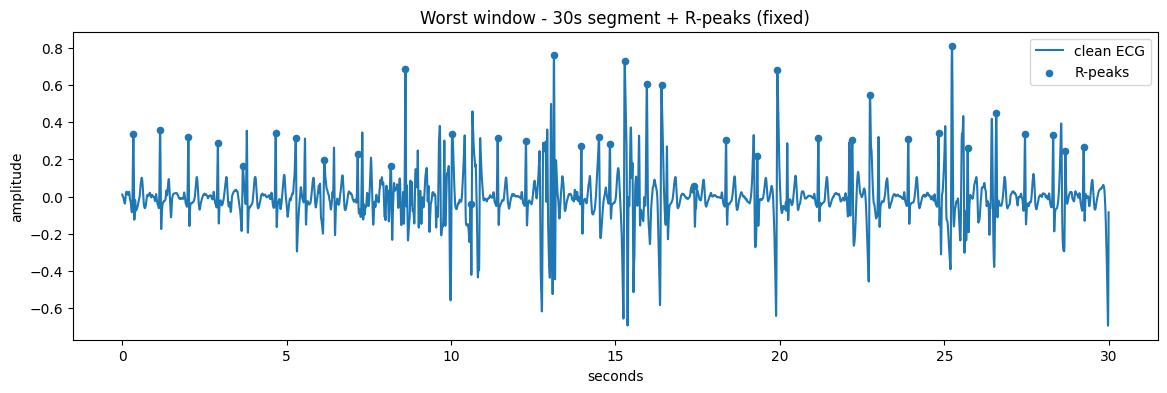

Beats extracted: 4279 | corr mean: 0.8205160157673982


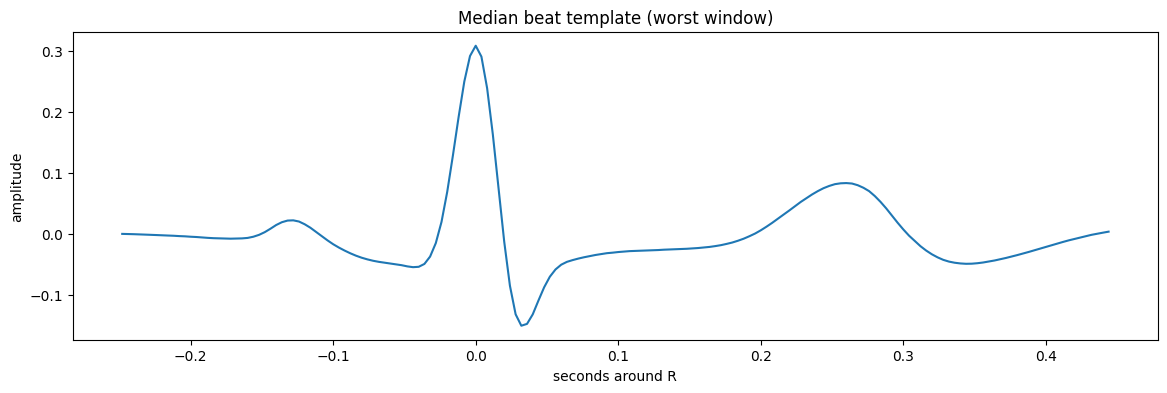

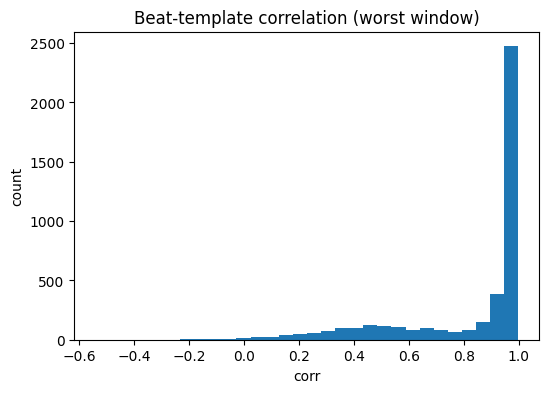

In [140]:
# =========================
# [Cell 21C] DEBUG: inspect the worst-quality window (low template_corr_mean)
# =========================

# pick worst window by template_corr_mean
assert "template_corr_mean" in feat_df.columns
worst = feat_df.sort_values("template_corr_mean", ascending=True).iloc[9]
print("Worst window:")
display(worst[["window_start","glucose_mean","n_rpeaks","n_beats","template_corr_mean","rr_outlier_frac"]])

i0, i1 = int(worst["ecg_i0"]), int(worst["ecg_i1"])
seg_raw = ecg.iloc[i0:i1+1].copy()
x0 = pd.to_numeric(seg_raw[ECG_COL], errors="coerce").to_numpy(dtype=float)
x0 = np.nan_to_num(x0)

# clean like in compute_window_features
x = bandpass(x0, fs=FS, low=0.5, high=40.0, order=4)
x = notch50(x, fs=FS, f0=50.0, Q=30.0)

# peaks (same logic)
if USE_NK:
    try:
        x_clean = nk.ecg_clean(x, sampling_rate=FS)
        _, info = nk.ecg_peaks(x_clean, sampling_rate=FS)
        rpeaks = np.array(info["ECG_R_Peaks"], dtype=int)
        x_use = x_clean
    except Exception as e:
        print("NK peak fail:", e)
        rpeaks = np.array([], dtype=int)
        x_use = x
else:
    prom = max(0.02, np.std(x) * 0.5)
    rpeaks, _ = find_peaks(x, distance=int(0.30*FS), prominence=prom)
    rpeaks = np.array(rpeaks, dtype=int)
    x_use = x

print("Detected rpeaks:", len(rpeaks))

# --- plot 30s around the middle (FIXED time axis)
mid = len(x_use)//2
a = max(0, mid - 15*FS)
b = min(len(x_use), mid + 15*FS)

t = (np.arange(a, b) - a) / FS  # <-- FIX: start at 0
plt.figure(figsize=(14,4))
plt.plot(t, x_use[a:b], label="clean ECG")

rr = rpeaks[(rpeaks >= a) & (rpeaks < b)]
plt.scatter((rr - a)/FS, x_use[rr], s=20, label="R-peaks")

plt.title("Worst window - 30s segment + R-peaks (fixed)")
plt.xlabel("seconds")
plt.ylabel("amplitude")
plt.legend()
plt.show()

# beat corr histogram + template
beats, keep = extract_beats(x_use, rpeaks, fs=FS, pre_s=0.25, post_s=0.45)
corrs = template_corr(beats)

print("Beats extracted:", beats.shape[0], "| corr mean:", np.mean(corrs) if len(corrs) else None)

if beats.shape[0] >= 5:
    tmpl = np.median(beats, axis=0)
    tt = (np.arange(len(tmpl)) - int(0.25*FS)) / FS

    plt.figure(figsize=(14,4))
    plt.plot(tt, tmpl)
    plt.title("Median beat template (worst window)")
    plt.xlabel("seconds around R")
    plt.ylabel("amplitude")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(corrs[np.isfinite(corrs)], bins=30)
    plt.title("Beat-template correlation (worst window)")
    plt.xlabel("corr")
    plt.ylabel("count")
    plt.show()

Original peaks: 3526 | corr mean: 0.506113412326468
Refined  peaks: 3526 | corr mean: 0.5098676893818596


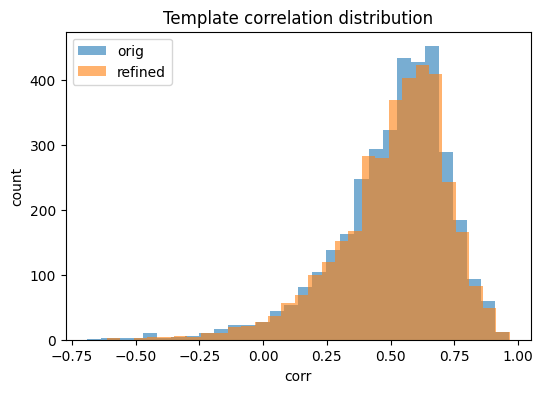

In [139]:
# =========================
# [Cell 21D] DEBUG: refine R-peaks locally and re-check template correlation
# =========================

def refine_peaks_local(sig, rpeaks, fs=FS, win_s=0.03):
    w = int(win_s * fs)
    out = []
    for rp in rpeaks:
        a = max(0, rp - w)
        b = min(len(sig), rp + w + 1)
        out.append(a + np.argmax(sig[a:b]))
    out = np.array(out, dtype=int)
    # remove duplicates (keep unique sorted)
    out = np.unique(out)
    return out

# Use the same worst window segment from 21C
rpeaks_ref = refine_peaks_local(x_use, rpeaks, fs=FS, win_s=0.03)

beats0, _ = extract_beats(x_use, rpeaks, fs=FS, pre_s=0.25, post_s=0.45)
c0 = template_corr(beats0)

beats1, _ = extract_beats(x_use, rpeaks_ref, fs=FS, pre_s=0.25, post_s=0.45)
c1 = template_corr(beats1)

print("Original peaks:", len(rpeaks), "| corr mean:", np.mean(c0) if len(c0) else None)
print("Refined  peaks:", len(rpeaks_ref), "| corr mean:", np.mean(c1) if len(c1) else None)

plt.figure(figsize=(6,4))
plt.hist(c0[np.isfinite(c0)], bins=30, alpha=0.6, label="orig")
plt.hist(c1[np.isfinite(c1)], bins=30, alpha=0.6, label="refined")
plt.title("Template correlation distribution")
plt.xlabel("corr")
plt.ylabel("count")
plt.legend()
plt.show()